## 1. Augmentation을 적용한 데이터셋 만들기
---
- 데이터셋에 CutMix 또는 Mixup augmentation을 적용하기

### 데이터 불러오기

In [44]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [45]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [46]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

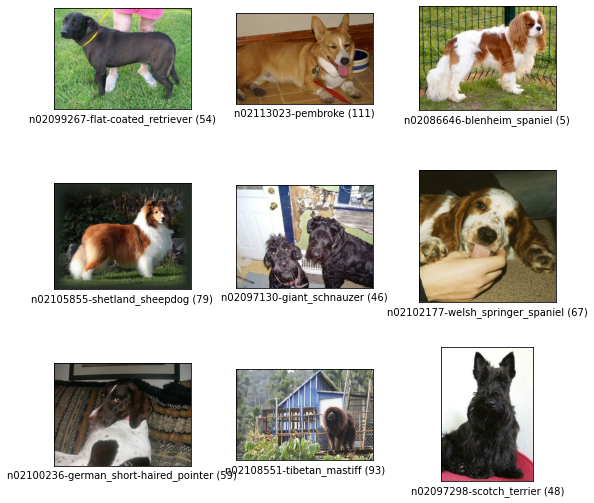

In [47]:
fig = tfds.show_examples(ds_train, ds_info)

### Augmentation 적용하기

In [48]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224,224])
    return tf.cast(image, tf.float32) / 255. , label

In [49]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [50]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [51]:
def augment2(image, label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, INPUT_SHAPE)
    return image, label

In [62]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [63]:
ds_train_dummy = apply_normalize_on_dataset(ds_train)

### 심화기법: Cutmix

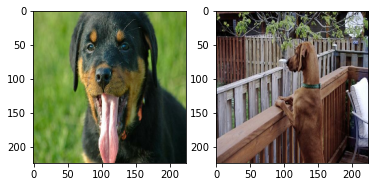

In [64]:
for i, (image, label) in enumerate(ds_train_dummy.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [65]:
def get_clip_box(image_a, image_b, img_size=224):
    x = tf.cast(tf.random.uniform([], 0, img_size), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, img_size), tf.int32)
    
    _prob = tf.random.uniform([], 0, 1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob), tf.int32)
    
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(10, shape=(), dtype=int32) tf.Tensor(114, shape=(), dtype=int32) tf.Tensor(198, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


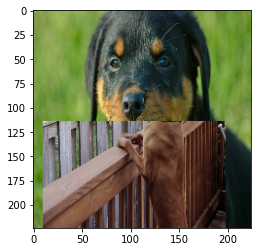

In [66]:
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb, 0:xa, :]
    two = image_b[ya:yb, xa:xb, :]
    three = image_a[ya:yb, xb:img_size, :]
    middle = tf.concat([one, two, three], axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom], axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [67]:
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa) * (yb-ya)
    total_area = img_size * img_size
    a = tf.cast(mixed_area/total_area, tf.float32)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a) * label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.41214922, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [68]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))
    
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.41214922
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.5878508
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.     

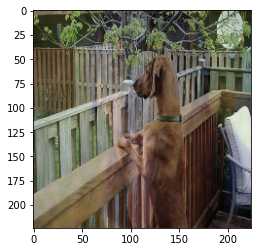

In [69]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, 120)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, 120)
    mixed_image = (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [70]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)
    
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [71]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    if not is_test and with_aug:
        ds = ds.map(augment)
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    if not is_test and with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [72]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [73]:
ds_train_no_aug

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [74]:
ds_test

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [75]:
ds_train_cutmix

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

## 2. 모델 만들기
---
- ResNet-50을 사용해 비교실험을 위한 모델 두개 만들기

In [76]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [77]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [23]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## 3. 모델 훈련하기
---
- cutmix와 mixup은 sparse_categorical_crossentropy() 대신 categorical_crossentropy() 사용!

### 바닐라

In [25]:
tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

In [26]:
history_resnet50 = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/20
  2/750 [..............................] - ETA: 58s - loss: 5.2521 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0600s vs `on_train_batch_end` time: 0.0944s). Check your callbacks.


750/750 [==============================] - 128s 171ms/step - loss: 2.1748 - accuracy: 0.4538 - val_loss: 3.6968 - val_accuracy: 0.1446
Epoch 2/20
750/750 [==============================] - 128s 171ms/step - loss: 0.7498 - accuracy: 0.7905 - val_loss: 1.8418 - val_accuracy: 0.5110
Epoch 3/20
750/750 [==============================] - 130s 174ms/step - loss: 0.3013 - accuracy: 0.9293 - val_loss: 0.9783 - val_accuracy: 0.7108
Epoch 4/20
750/750 [==============================] - 130s 173ms/step - loss: 0.1130 - accuracy: 0.9830 - val_loss: 0.9312 - val_accuracy: 0.7322
Epoch 5/20
750/750 [==============================] - 130s 173ms/step - loss: 0.0508 - accuracy: 0.9954 - val_loss: 0.9111 - val_accuracy: 0.7431
Epoch 6/20
750/750 [==============================] - 130s 173ms/step - loss: 0.0300 - accuracy: 0.9978 - val_loss: 0.9349 - val_accuracy: 0.7423
Epoch 7/20
750/750 [==============================] - 130s 173ms/step - loss: 0.0219 - accuracy: 0.9987 - val_loss: 0.9179 - val_accura

### 기본 Aug

In [27]:
resnet50_aug.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

In [28]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/20
750/750 [==============================] - 119s 159ms/step - loss: 2.2619 - accuracy: 0.4364 - val_loss: 2.9146 - val_accuracy: 0.2732
Epoch 2/20
750/750 [==============================] - 119s 158ms/step - loss: 0.8945 - accuracy: 0.7472 - val_loss: 1.3521 - val_accuracy: 0.6084
Epoch 3/20
750/750 [==============================] - 120s 160ms/step - loss: 0.5006 - accuracy: 0.8606 - val_loss: 1.2420 - val_accuracy: 0.6524
Epoch 4/20
750/750 [==============================] - 122s 163ms/step - loss: 0.2771 - accuracy: 0.9337 - val_loss: 1.0984 - val_accuracy: 0.6927
Epoch 5/20
750/750 [==============================] - 118s 157ms/step - loss: 0.1743 - accuracy: 0.9599 - val_loss: 1.1272 - val_accuracy: 0.6845
Epoch 6/20
750/750 [==============================] - 123s 164ms/step - loss: 0.0948 - accuracy: 0.9836 - val_loss: 0.9891 - val_accuracy: 0.7240
Epoch 7/20
750/750 [==============================] - 120s 160ms/step - loss: 0.0839 - accuracy: 0.9857 - val_loss: 0.9598 -

### CutMix

In [78]:
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

In [2]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

NameError: name 'resnet50_cutmix' is not defined

## 4. 훈련 과정 시각화하기
---
- 훈련 과정의 히스토리를 그래프로 시각화

## 5. Augmentation에 의한 모델 성능 비교하기
---
- No Augmentation
- 기본 Augmentation
- 기본 + CutMix 
- 기본 + Mixup  
이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교하고 Augmentation 방법들의 영향도에 대해 분석해보기